In [1]:
# 1. Installazioni necessarie per Colab
!pip install transformers[torch] textstat accelerate -U

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.6/176.6 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.4 MB/s eta 0:00:00


In [2]:
!pip install -q transformers torch scikit-learn seaborn tqdm


In [ ]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW # Moved AdamW import here

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    confusion_matrix
)

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(" Device:", device)
print("GPU:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")

🖥️ Device: cuda
🔥 GPU: Tesla T4


In [4]:
df = pd.read_csv("ai_human_with_signatures.csv")

print("Dataset shape:", df.shape)
print("\nClass distribution:")
print(df["label_encoded"].value_counts())


Dataset shape: (500, 63)

Class distribution:
label_encoded
1    251
0    249
Name: count, dtype: int64


In [5]:
stylometric_features = [
    'sentence_length_cv', 'burstiness_index', 'pos_bigram_entropy',
    'dependency_depth_mean', 'lexical_compression_ratio',
    'function_word_ratio', 'sentence_similarity_drift',
    'structural_redundancy', 'sentiment_variance',
    'readability_oscillation', 'clause_density',
    'hapax_density', 'template_bias_score'
]

stylometric_features = [f for f in stylometric_features if f in df.columns]
print(f"Using {len(stylometric_features)} stylometric features")


Using 13 stylometric features


In [ ]:
# Verifica che tutte le feature esistano
missing_features = [f for f in stylometric_features if f not in df.columns]
if missing_features:
    print(f"⚠️  Missing features: {missing_features}")
    stylometric_features = [f for f in stylometric_features if f in df.columns]

print(f" Using {len(stylometric_features)} stylometric features\n")



✅ Using 13 stylometric features



In [ ]:
X_text = df["text"].fillna("").astype(str).values  
X_feat = df[stylometric_features].values
y = df["label_encoded"].values

# Single split for all models (70% train, 15% val, 15% test)
X_text_temp, X_text_test, X_feat_temp, X_feat_test, y_temp, y_test = train_test_split(
    X_text, X_feat, y, test_size=0.15, stratify=y, random_state=42
)

X_text_train, X_text_val, X_feat_train, X_feat_val, y_train, y_val = train_test_split(
    X_text_temp, X_feat_temp, y_temp, test_size=0.176, stratify=y_temp, random_state=42  # 0.176 * 0.85 ≈ 0.15
)

print("Data Split:")
print(f"   Train: {len(y_train)} samples ({np.mean(y_train == 1):.1%} AI)")
print(f"   Val:   {len(y_val)} samples ({np.mean(y_val == 1):.1%} AI)")
print(f"   Test:  {len(y_test)} samples ({np.mean(y_test == 1):.1%} AI)\n")

📊 Train set: 400 samples (50.2% AI)
📊 Test set:  100 samples (50.0% AI)



In [ ]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
sample_lengths = [len(tokenizer.encode(text, truncation=False)) for text in X_text_train[:1000]]
p90 = np.percentile(sample_lengths, 90)
print(f"📏 Text length analysis (90th percentile): {int(p90)} tokens")
MAX_LENGTH = min(512, max(128, int(p90)))  # Cap at 512, min 128
print(f"   Using MAX_LENGTH = {MAX_LENGTH}\n")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            str(self.texts[idx]),
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

In [ ]:
print("=" * 70)
print(" MODEL 1: BERT FINE-TUNED")
print("=" * 70)

model_bert = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False
).to(device)

print(f" BERT loaded: {sum(p.numel() for p in model_bert.parameters()):,} parameters\n")

# Create datasets
train_dataset = TextDataset(X_text_train, y_train, tokenizer, MAX_LENGTH)
val_dataset = TextDataset(X_text_val, y_val, tokenizer, MAX_LENGTH)
test_dataset = TextDataset(X_text_test, y_test, tokenizer, MAX_LENGTH)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

🤖 MODEL 1: BERT FINE-TUNED


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model loaded: 109,483,778 parameters



In [ ]:
optimizer = AdamW(model_bert.parameters(), lr=2e-5, eps=1e-8)
epochs = 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps=0, 
    num_training_steps=total_steps)


# Training function
def train_epoch(model, dataloader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch['input_ids'].to(device),
            attention_mask=batch['attention_mask'].to(device),
            labels=batch['labels'].to(device)
        )
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
    return total_loss / len(dataloader)

In [ ]:
# Evaluation function
def evaluate(model, dataloader, device):
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            outputs = model(
                input_ids=batch['input_ids'].to(device),
                attention_mask=batch['attention_mask'].to(device)
            )
            preds = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(batch['labels'].numpy())
    return np.array(predictions), np.array(true_labels)


In [ ]:
# Training loop
print("Training BERT...")
best_val_acc = 0
for epoch in range(epochs):
    print(f"\n📍 Epoch {epoch + 1}/{epochs}")
    avg_loss = train_epoch(model_bert, train_loader, optimizer, scheduler, device)
    print(f"   Train loss: {avg_loss:.4f}")
    
    # Validation
    val_preds, val_labels = evaluate(model_bert, val_loader, device)
    val_acc = accuracy_score(val_labels, val_preds)
    print(f"   Val accuracy: {val_acc:.4f}")
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model_bert.state_dict(), 'best_bert.pth')
        print(f" Best model saved!")

# Load best model and evaluate on test
model_bert.load_state_dict(torch.load('best_bert.pth'))
y_pred_bert, _ = evaluate(model_bert, test_loader, device)

acc = accuracy_score(y_test, y_pred_bert)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_bert, average='weighted')

print(f"\nBERT Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}\n")



🏋️  Training BERT...

📍 Epoch 1/3


Training: 100%|██████████| 25/25 [00:09<00:00,  2.64it/s]


   Average loss: 0.4967


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.19it/s]


   Validation accuracy: 0.9900

📍 Epoch 2/3


Training: 100%|██████████| 25/25 [00:07<00:00,  3.23it/s]


   Average loss: 0.1180


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.77it/s]


   Validation accuracy: 1.0000

📍 Epoch 3/3


Training: 100%|██████████| 25/25 [00:07<00:00,  3.19it/s]


   Average loss: 0.0239


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  7.61it/s]


   Validation accuracy: 1.0000

📊 Final BERT Evaluation:


Evaluating: 100%|██████████| 7/7 [00:00<00:00,  8.61it/s]

   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000



In [ ]:
# ============================================================================
# 5. HYBRID MODEL (BERT + Stylometric Features)
# ============================================================================

print("=" * 70)
print(" MODEL 2: HYBRID (BERT + Stylometric)")
print("=" * 70)

def get_bert_embeddings(texts, model, tokenizer, device, max_length, batch_size=16):
    model.eval()
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting embeddings"):
            batch = texts[i:i+batch_size]
            encoded = tokenizer(
                list(batch),
                add_special_tokens=True,
                max_length=max_length,
                padding='max_length',
                truncation=True,
                return_tensors='pt'
            )
            outputs = model.bert(
                input_ids=encoded['input_ids'].to(device),
                attention_mask=encoded['attention_mask'].to(device)
            )
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    return np.vstack(embeddings)

print(" Extracting BERT embeddings...")
bert_train = get_bert_embeddings(X_text_train, model_bert, tokenizer, device, MAX_LENGTH)
bert_val = get_bert_embeddings(X_text_val, model_bert, tokenizer, device, MAX_LENGTH)
bert_test = get_bert_embeddings(X_text_test, model_bert, tokenizer, device, MAX_LENGTH)


🔬 MODEL 2: HYBRID (BERT Embeddings + Stylometric Features)
🔄 Extracting BERT embeddings...


Extracting embeddings: 100%|██████████| 7/7 [00:00<00:00,  9.83it/s]


In [ ]:
# Scala feature stilometriche
scaler = StandardScaler()
X_feat_train_scaled = scaler.fit_transform(X_feat_train)
X_feat_val_scaled = scaler.transform(X_feat_val)
X_feat_test_scaled = scaler.transform(X_feat_test)

# Combine features
X_hybrid_train = np.hstack([bert_train, X_feat_train_scaled])
X_hybrid_val = np.hstack([bert_val, X_feat_val_scaled])
X_hybrid_test = np.hstack([bert_test, X_feat_test_scaled])

print(f" Hybrid shape: {X_hybrid_train.shape}")
print(f"   BERT: {bert_train.shape[1]} dims | Stylometric: {X_feat_train_scaled.shape[1]} dims\n")


✅ Hybrid features shape: (400, 781)
   - BERT embeddings: 768 dims
   - Stylometric features: 13 dims



In [ ]:
# Train Random Forest su hybrid features
print("Training Random Forest...")
rf_hybrid = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_hybrid.fit(X_hybrid_train, y_train)

y_pred_hybrid = rf_hybrid.predict(X_hybrid_test)
y_proba_hybrid = rf_hybrid.predict_proba(X_hybrid_test)[:, 1]

acc = accuracy_score(y_test, y_pred_hybrid)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_hybrid, average='weighted')
auc = roc_auc_score(y_test, y_proba_hybrid)

print(f"\n Hybrid Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {auc:.4f}\n")

🌲 Training Random Forest on Hybrid Features...

📊 Hybrid Model Performance:
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1-Score:  1.0000
   ROC-AUC:   1.0000



In [ ]:
print("=" * 70)
print(" MODEL 3: BASELINE (Stylometric Only)")
print("=" * 70)

rf_baseline = RandomForestClassifier(
    n_estimators=200,
    max_depth=20,
    min_samples_split=5,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)
rf_baseline.fit(X_feat_train_scaled, y_train)

y_pred_baseline = rf_baseline.predict(X_feat_test_scaled)
y_proba_baseline = rf_baseline.predict_proba(X_feat_test_scaled)[:, 1]

acc = accuracy_score(y_test, y_pred_baseline)
prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred_baseline, average='weighted')
auc = roc_auc_score(y_test, y_proba_baseline)

print(f"\n Baseline Test Performance:")
print(f"   Accuracy:  {acc:.4f}")
print(f"   Precision: {prec:.4f}")
print(f"   Recall:    {rec:.4f}")
print(f"   F1-Score:  {f1:.4f}")
print(f"   ROC-AUC:   {auc:.4f}\n")

📐 MODEL 3: BASELINE (Stylometric Features Only)

📊 Baseline Performance:
   Accuracy:  0.8600
   Precision: 0.8653
   Recall:    0.8600
   F1-Score:  0.8595
   ROC-AUC:   0.9392



In [ ]:
# Feature importance
importances = rf_baseline.feature_importances_
feature_ranking = pd.DataFrame({
    'feature': stylometric_features,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 5 Most Important Stylometric Features:")
print(feature_ranking.head(5).to_string(index=False))
print()

📊 MODEL COMPARISON
                Model  Accuracy  F1-Score
      BERT Fine-tuned      1.00  1.000000
  Hybrid (BERT+Style)      1.00  1.000000
Baseline (Style Only)      0.86  0.859494

✅ Visualization saved: 'model_comparison.png'



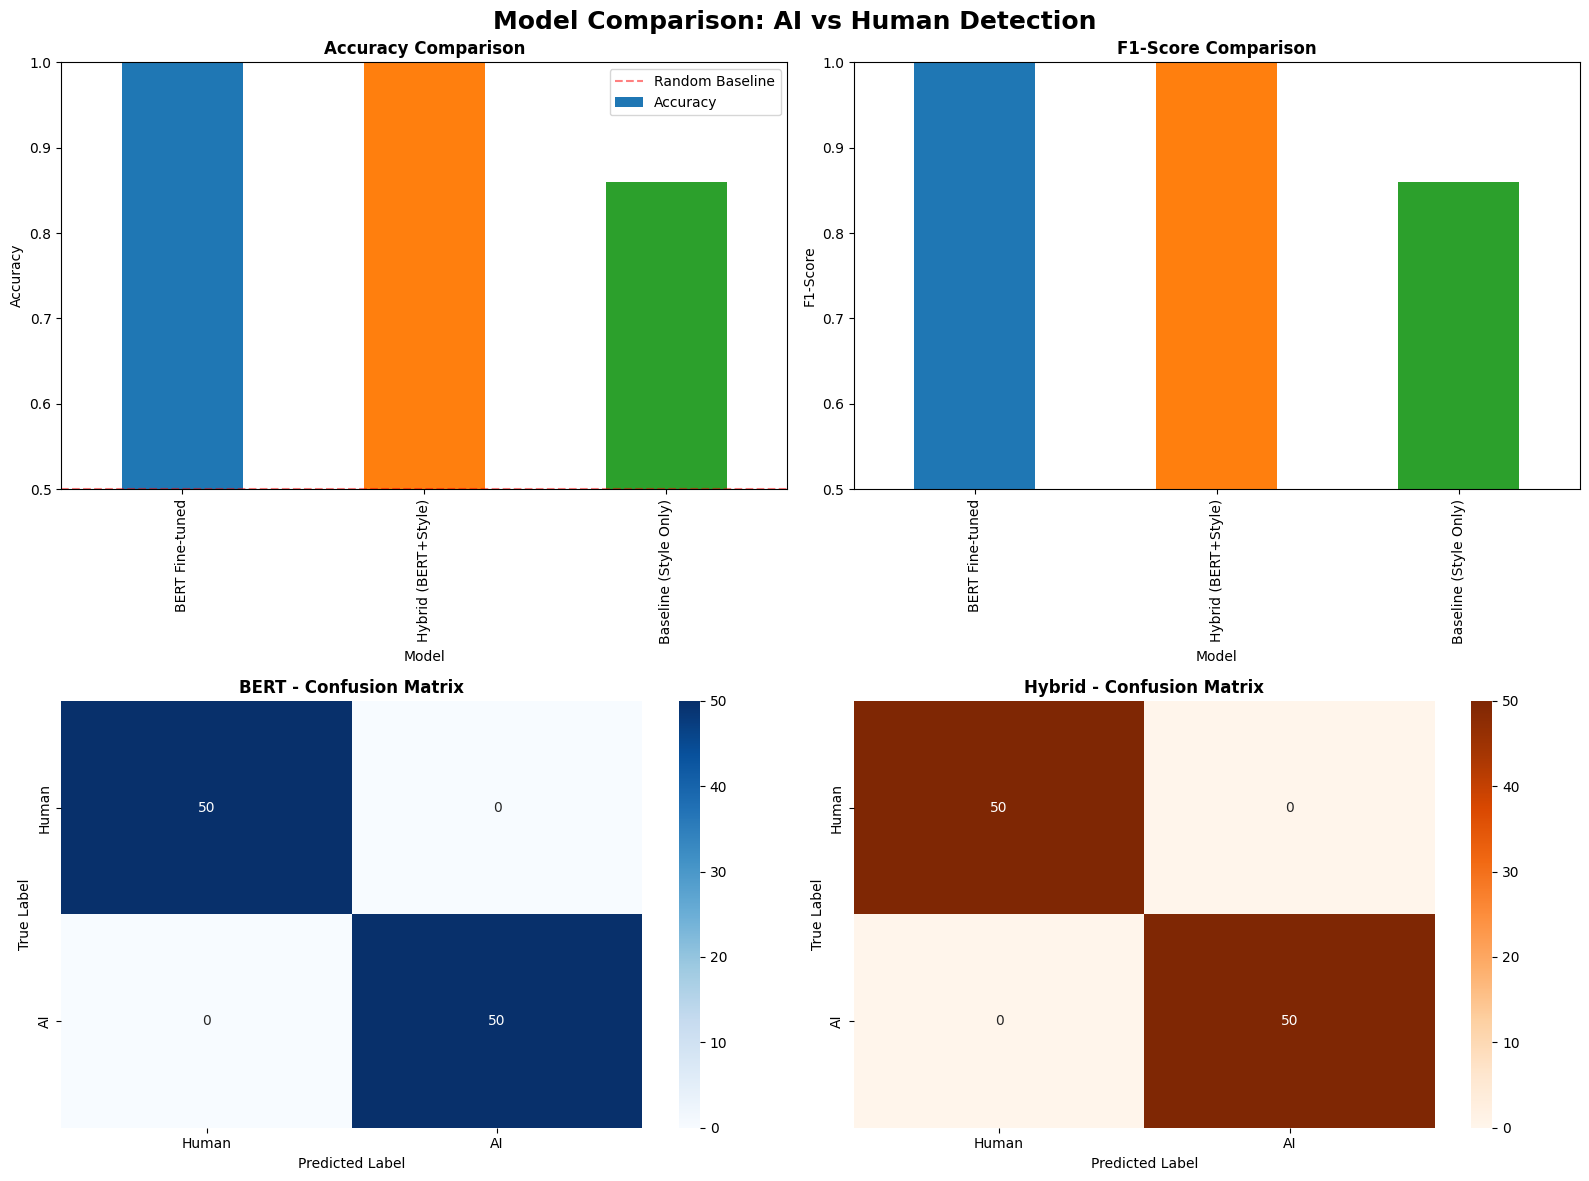

In [ ]:
print("=" * 70)
print(" MODEL COMPARISON")
print("=" * 70)

# Crea DataFrame comparativo
results = pd.DataFrame({
    'Model': ['BERT Fine-tuned', 'Hybrid (BERT+Style)', 'Baseline (Style Only)'],
    'Accuracy': [
        accuracy_score(y_test, y_pred_bert),
        accuracy_score(y_test, y_pred_hybrid),
        accuracy_score(y_test, y_pred_baseline)
    ],
    'F1-Score': [
        precision_recall_fscore_support(y_test, y_pred_bert, average='weighted')[2],
        precision_recall_fscore_support(y_test, y_pred_hybrid, average='weighted')[2],
        precision_recall_fscore_support(y_test, y_pred_baseline, average='weighted')[2]
    ]
})

print(results.to_string(index=False))
print()

# Visualizzazione
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Comparison: AI vs Human Detection', fontsize=18, fontweight='bold')

# Plot 1: Accuracy Comparison
ax = axes[0, 0]
results.plot(x='Model', y='Accuracy', kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)
ax.set_title('Accuracy Comparison', fontweight='bold')
ax.set_ylabel('Accuracy')
ax.set_ylim([0.5, 1.0])
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random Baseline')
ax.legend()

# Plot 2: F1-Score Comparison
ax = axes[0, 1]
results.plot(x='Model', y='F1-Score', kind='bar', ax=ax, color=['#1f77b4', '#ff7f0e', '#2ca02c'], legend=False)
ax.set_title('F1-Score Comparison', fontweight='bold')
ax.set_ylabel('F1-Score')
ax.set_ylim([0.5, 1.0])

# Plot 3: Confusion Matrix - BERT
ax = axes[1, 0]
cm_bert = confusion_matrix(y_test, y_pred_bert)
sns.heatmap(cm_bert, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_title('BERT - Confusion Matrix', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

# Plot 4: Confusion Matrix - Hybrid
ax = axes[1, 1]
cm_hybrid = confusion_matrix(y_test, y_pred_hybrid)
sns.heatmap(cm_hybrid, annot=True, fmt='d', cmap='Oranges', ax=ax,
            xticklabels=['Human', 'AI'], yticklabels=['Human', 'AI'])
ax.set_title('Hybrid - Confusion Matrix', fontweight='bold')
ax.set_ylabel('True Label')
ax.set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("✅ Visualization saved: 'model_comparison.png'\n")



In [ ]:
print("=" * 70)
print(" SAVING MODELS")
print("=" * 70)

model_bert.save_pretrained('./bert_ai_detector')
tokenizer.save_pretrained('./bert_ai_detector')
joblib.dump(rf_hybrid, 'rf_hybrid_model.pkl')
joblib.dump(rf_baseline, 'rf_baseline_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

# Save feature list and config
with open('stylometric_features.txt', 'w') as f:
    f.write('\n'.join(stylometric_features))

config = {
    'max_length': MAX_LENGTH,
    'n_features': len(stylometric_features),
    'bert_dim': bert_train.shape[1]
}
joblib.dump(config, 'model_config.pkl')

print(" All models saved successfully!")
print(f"   - BERT: ./bert_ai_detector/")
print(f"   - Hybrid RF: rf_hybrid_model.pkl")
print(f"   - Baseline RF: rf_baseline_model.pkl")
print(f"   - Scaler: feature_scaler.pkl")
print(f"   - Config: model_config.pkl")
print(f"   - Features: stylometric_features.txt\n")

print("=" * 70)
print(" TRAINING COMPLETED!")
print("=" * 70)

💾 SAVING MODELS
✅ BERT model saved to './bert_ai_detector'
✅ Hybrid model saved to 'rf_hybrid_model.pkl'
✅ Baseline model saved to 'rf_baseline_model.pkl'

✅ TRAINING COMPLETED!
